In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold, KFold
import os
from model import MNISTClassifier, COLOR_LIST, GPU_DEVICE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

## Parameters

In [2]:
#Parameters for CNN
num_epochs=10
batch_size=128
#Parameters for KFold Cross validation
K=3
#Path to saved models
model_path='models/best_model_MNIST.pt'


## Importing our Model: CNN with Mini-Batch Gradient Descent

In [3]:
model = MNISTClassifier(num_epochs=num_epochs,batch_size=batch_size)
model = model.to(GPU_DEVICE)


## Data Preparation

In [4]:
# transforms for images
#The mean and variance are calculated beforehand (0.1305,0.3081)
transform=transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.1305,), (0.3081,))])

# prepare transforms standard to MNIST
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)

#Load test data and tranfer it to GPU
test_data=model.test_dataloader(mnist_test)

### Data Visualization

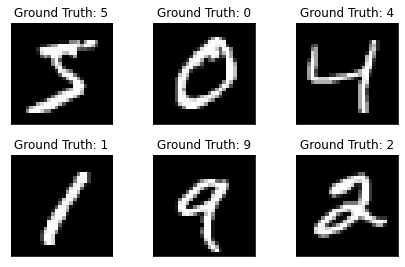

In [5]:
examples = enumerate(model.train_dataloader(mnist_train))
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Training with KFold Cross Validation

In [6]:
KF_splits = KFold(n_splits= K, shuffle = True, random_state = 42)


Crossvalidation fold: 1/3
Epoch [1/10], Step [100/313], Loss: 0.3754
Epoch [1/10], Step [200/313], Loss: 0.1956
Epoch [1/10], Step [300/313], Loss: 0.0779
Epoch [2/10], Step [100/313], Loss: 0.2281
Epoch [2/10], Step [200/313], Loss: 0.0701
Epoch [2/10], Step [300/313], Loss: 0.1750
Epoch [3/10], Step [100/313], Loss: 0.1458
Epoch [3/10], Step [200/313], Loss: 0.1550
Epoch [3/10], Step [300/313], Loss: 0.2263
Epoch [4/10], Step [100/313], Loss: 0.0628
Epoch [4/10], Step [200/313], Loss: 0.0712
Epoch [4/10], Step [300/313], Loss: 0.0264
Epoch [5/10], Step [100/313], Loss: 0.0702
Epoch [5/10], Step [200/313], Loss: 0.1441
Epoch [5/10], Step [300/313], Loss: 0.1470
Epoch [6/10], Step [100/313], Loss: 0.1152
Epoch [6/10], Step [200/313], Loss: 0.0339
Epoch [6/10], Step [300/313], Loss: 0.0722
Epoch [7/10], Step [100/313], Loss: 0.1263
Epoch [7/10], Step [200/313], Loss: 0.1372
Epoch [7/10], Step [300/313], Loss: 0.1221
Epoch [8/10], Step [100/313], Loss: 0.1892
Epoch [8/10], Step [200/313

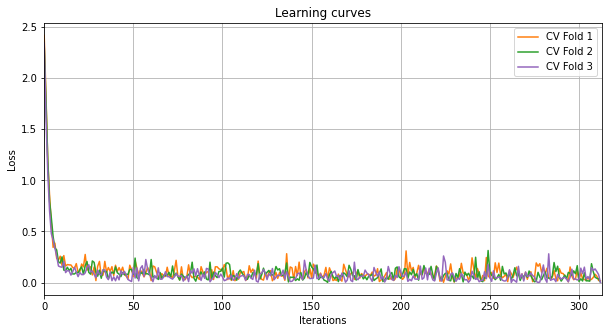

In [7]:
models=[]
losses=[]
fig, ax = plt.subplots(1,1, figsize=(10,5))
best_loss=1e2
for (k,(train_idx, valid_idx)) in enumerate(KF_splits.split(mnist_train)):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))  
    #Sample Train and Validation data
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_data=model.train_dataloader(mnist_train,sampler=train_sampler)
    val_data=model.test_dataloader(mnist_train,sampler=valid_sampler)
    #Compute Traning and get best_model, loss and learning curve across epochs
    best_model, best_final_loss, best_learning_curve =model.compute_training(train_data)
    #Plot best learning curve
    model.plot_learning_curve(best_learning_curve,
                                    ax=ax,
                                    label='CV Fold {}'.format(k+1),
                                    color=COLOR_LIST[k])
    print('\nBest loss: {}\n'.format(best_final_loss))
    if best_final_loss < best_loss:
        torch.save(best_model, model_path)
        best_loss=best_final_loss

plt.legend()
plt.grid()
plt.show()

## Evaluation

In [10]:
best_model_params = torch.load(model_path)

test_loss, y_true, y_pred=model.compute_validation(test_data)
model.load_state_dict(best_model_params)
model.to(GPU_DEVICE)
model.eval()
print('Test loss: ', test_loss)

Test loss:  0.03772517666220665


Normalized confusion matrix


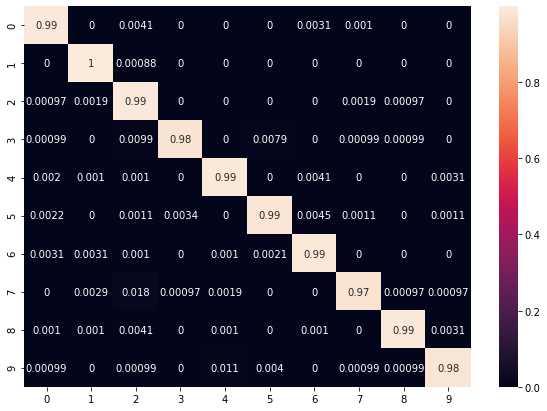

In [11]:
normalize=True
plt.figure(figsize=(10,7))
cm= confusion_matrix(y_true, y_pred.argmax(dim=1))
# Only use the labels that appear in the data
#classes = classes[unique_labels(y_true, y_pred)]
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')
sns.heatmap(cm, annot=True)
plt.show()